In [1]:
import arviz as az
import numpy as np
import pymc3 as pm
import scipy.stats as st
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sbi import *

https://www.youtube.com/watch?v=5nM5e2_1OQ0

https://tutorials.sciml.ai/html/model_inference/02-monte_carlo_parameter_estim.html

http://www-personal.umd.umich.edu/~wiclarks/AstroLab/HOWTOs/NotebookStuff/MonteCarloHOWTO.html

http://www2.compute.dtu.dk/~pcha/UQ/DTU_dec18.pdf


https://lucidmanager.org/data-science/monte-carlo-cost-estimates/

https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

https://docs.pymc.io/en/v3/pymc-examples/examples/samplers/SMC-ABC_Lotka-Volterra_example.html

https://www.readcube.com/articles/10.3389/feart.2015.00054

In [18]:
# Read in Katies model runs
Young2020 = xr.open_dataset("notebooks/Young_etal_2020_Delta_T_-0.9_C.nc")
# Fit the air temperature function to Katies results
AirTemp_params = fit_airtemp(Young2020)

AirTemp_params['T_mean'] = AirTemp_params['T_mean'] + 1.5

# instantiate the AirTemp class using the parameters from the curve fitting
Temp = AirTemp(**AirTemp_params)

# Read in the lilk model results
#with xr.open_dataset('../../initialization/coarse/result/twds-b/nc/twds-b_2000a_dt_1_dx_500_MB_9.29_OFF_spline.nc') as src:
with xr.open_dataset('../../initialization/coarse/result/crmpt18-a/nc/crmpt18-a_1000a_dt_1_dx_100_MB_00.0_OFF.nc') as src:
    # correct for minimum ice thickness
    src["depth"] = xr.where(src.depth <= 10, 0, src.depth)
    # apply sigma coordinate transform for vertical coordinate
    src["Z"]     = src.zbed + src.Z * src.height
    # Calculate the magnitude of the velocity vectors
    src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)

# Surface Elevation Vector
Z      = src.Z.isel(t=-1, coord_2=-1).values[np.newaxis, :]
MB     = src["zs accumulation flux 2"].isel(t=-1, coord_2=-1).values[np.newaxis, :]
z_ELA  = Z[0, np.argpartition(np.abs(src["zs accumulation flux 2"].isel(t=-1, coord_2=-1).values), 5)[:5]].mean()
z_ref  = Young2020.stack(z=('x', 'y')).Elevation.mean().values
A_mean = Young2020.stack(z=('x', 'y')).Accumulation.mean().values * 910

In [19]:
# instantiate the MassBalance class
model = MassBalance(Z=Z, Temp=Temp, A_mean=A_mean)

def simulator(f_snow, f_r, grad_A):
    return model.eval(f_snow=f_snow, f_r=f_r, grad_A=grad_A)

In [20]:
with pm.Model() as model_mb:
    # Braithwaite (2008) / Rounce et al. 2020
    f_snow = pm.TruncatedNormal("f_snow", mu=4.1, sigma=1.5, lower=0)  
    # Naive refreezing factor prior
    f_r    = pm.Uniform("f_r", 0.0, 1.0)
    # Percipitation Lapse Rate
    grad_A = pm.TruncatedNormal("grad_A", mu=4.0e-4, sigma=1.0e-3, lower=0)  
    
    sim = pm.Simulator("sims", simulator, params=(f_snow, f_r, grad_A), epsilon=0.1, observed=MB)
    
    trace_mb = pm.sample_smc(draws=2000, kernel="ABC", chains=3, parallel=False)
    idata_mb = az.from_pymc3(trace_mb,)


Initializing SMC sampler...
Sampling 3 chains in 2 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.001
Stage:   2 Beta: 0.003
Stage:   3 Beta: 0.008
Stage:   4 Beta: 0.019
Stage:   5 Beta: 0.041
Stage:   6 Beta: 0.092
Stage:   7 Beta: 0.201
Stage:   8 Beta: 0.434
Stage:   9 Beta: 0.940
Stage:  10 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.001
Stage:   2 Beta: 0.003
Stage:   3 Beta: 0.008
Stage:   4 Beta: 0.019
Stage:   5 Beta: 0.042
Stage:   6 Beta: 0.092
Stage:   7 Beta: 0.206
Stage:   8 Beta: 0.449
Stage:   9 Beta: 0.982
Stage:  10 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.001
Stage:   2 Beta: 0.003
Stage:   3 Beta: 0.008
Stage:   4 Beta: 0.019
Stage:   5 Beta: 0.042
Stage:   6 Beta: 0.095
Stage:   7 Beta: 0.211
Stage:   8 Beta: 0.461
Stage:   9 Beta: 1.000


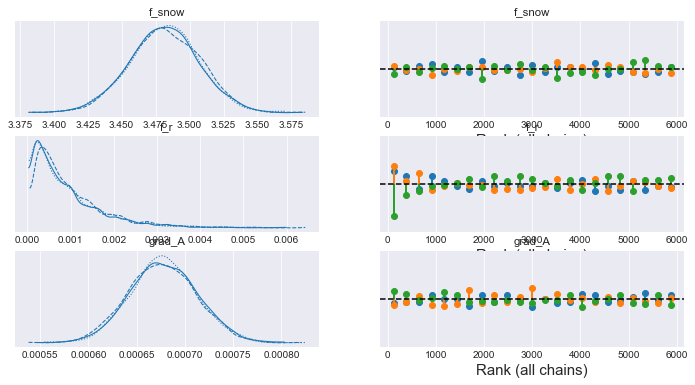

In [21]:
az.plot_trace(idata_mb, kind="rank_vlines");

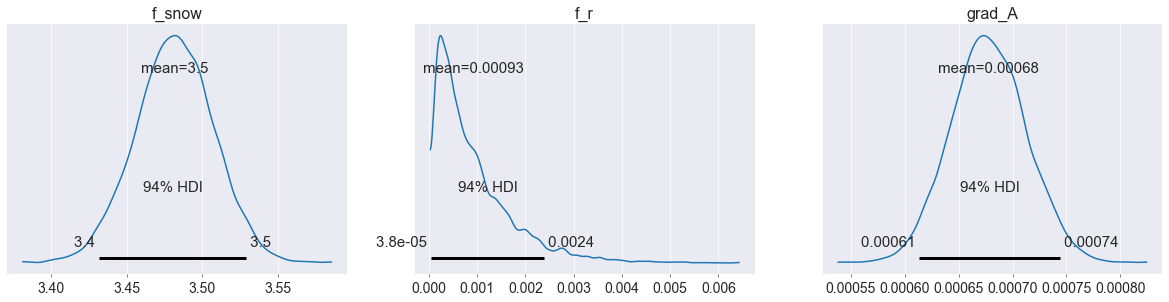

In [22]:
az.plot_posterior(idata_mb);

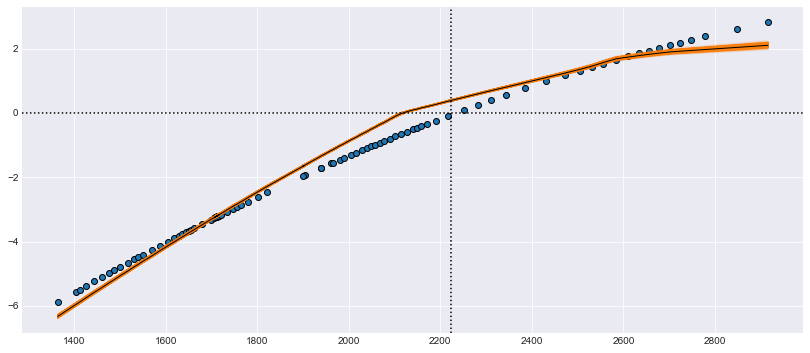

In [23]:
# plot results
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(Z[0], MB[0,:], "o", label="prey", c="C0", mec="k")


for i in np.random.randint(0, len(trace_mb["f_snow"]), 1000):
    sim = simulator(trace_mb["f_snow"][i], trace_mb["f_r"][i], trace_mb["grad_A"][i]);
    ax.plot(Z[0], sim[0], alpha=0.1, c="C1")
    
ax.plot(Z[0], simulator(trace_mb["f_snow"].mean(),  
                        trace_mb["f_r"].mean(),
                        trace_mb["grad_A"].mean())[0], 
        c = 'k', linewidth=1.0);

ax.axhline(0.0,   c='k', ls=":")
ax.axvline(z_ELA, c='k', ls=":")

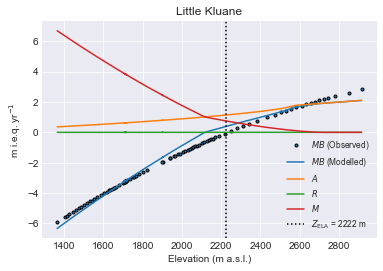

In [24]:
_ = model.eval(f_snow=trace_mb["f_snow"].mean(),  
               f_r=trace_mb["f_r"].mean(),
               grad_A=trace_mb["grad_A"].mean())[0]


fig, ax = plt.subplots(1,1)

ax.plot(Z[0], MB[0], 'o', c="C0", mec="k", ms=3.0, label='$MB$ (Observed)')
ax.plot(Z[0], model.arrays['MB'][0], label='$MB$ (Modelled)')
ax.plot(Z[0], model.arrays['A' ][0]*(1/910), label="$A$")
ax.plot(Z[0], model.arrays['R' ][0]*(1/910), label="$R$")
ax.plot(Z[0], model.arrays['M' ][0]*(1/910), label="$M$")


ax.axvline(z_ELA, c='k', ls=":", label='$Z_{{\\rm ELA}}$ = {:.0f} m'.format(z_ELA))

ax.legend(fontsize='small')
ax.set_title('Little Kluane')
ax.set_ylabel('m i.e.q. yr$^{-1}$')
ax.set_xlabel('Elevation (m a.s.l.)')

plt.savefig("/Users/andrewnolan/Desktop/MB_component.png", dpi=300, 
            bbox_inches='tight', facecolor='w')

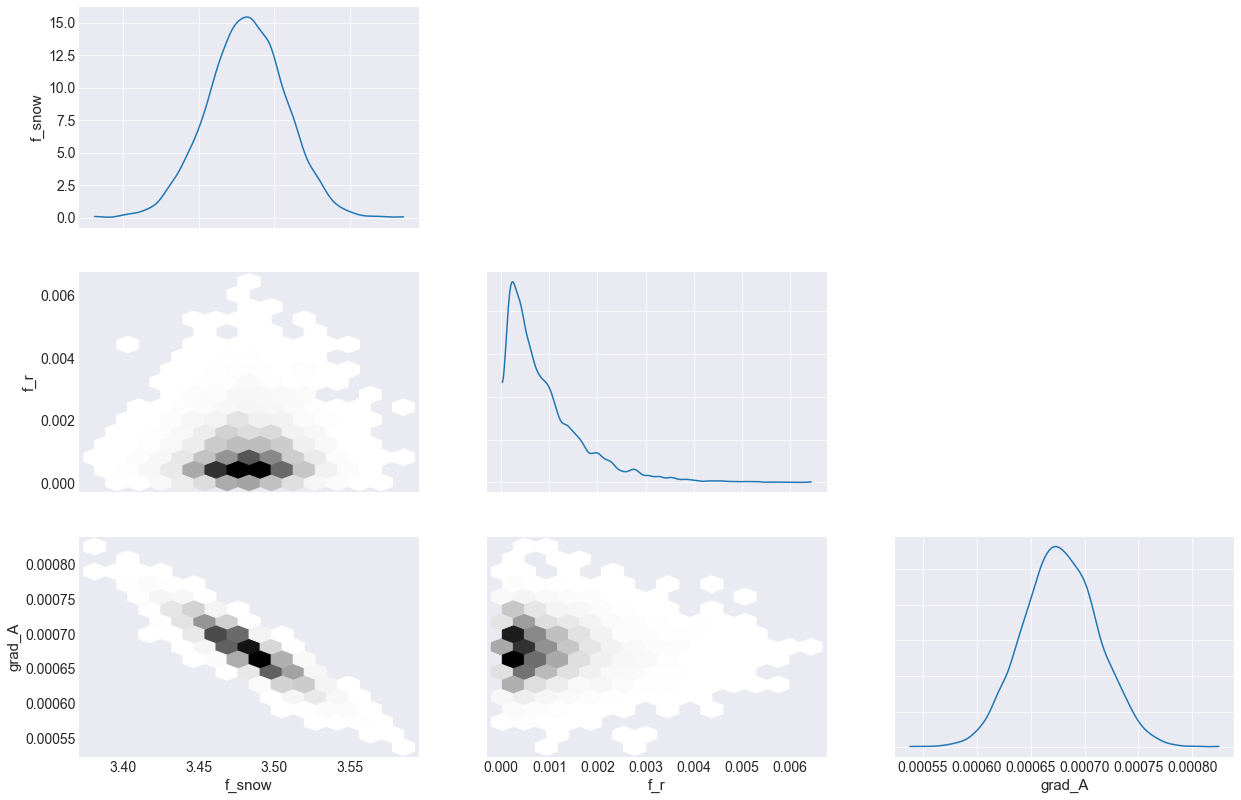

In [25]:
axes = az.plot_pair( idata_mb, 
                     kind="hexbin",
                     marginals=True)

plt.savefig('/Users/andrewnolan/Desktop/posteriors.png', dpi=300, 
            bbox_inches='tight', facecolor='w')

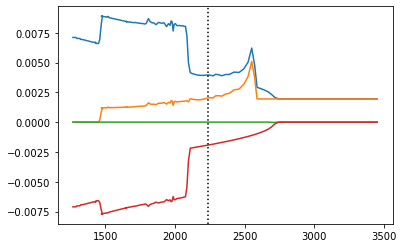

In [10]:
plt.plot(Z[0], np.gradient(model.arrays['MB'][0], Z[0]))
plt.plot(Z[0], np.gradient(model.arrays['A'][0]*(1/910), Z[0]))
plt.plot(Z[0], np.gradient(model.arrays['R'][0]*(1/910), Z[0]))
plt.plot(Z[0], np.gradient(model.arrays['M'][0]*(1/910), Z[0]))


plt.axvline(z_ELA, c='k', ls=":", label='$Z_{\\rm ELA}$')


In [11]:
DOYs = np.linspace(1,365,365,dtype=int)[:, np.newaxis]

T_s  = AirTemp(**AirTemp_params).eval(Z, DOYs)

PDDs = np.where(T_s>273.15,  T_s-273.15, 0).sum(axis=0)


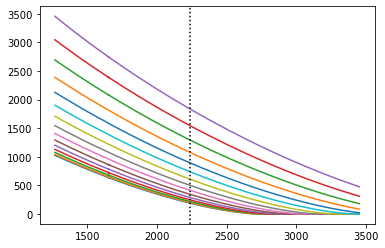

In [12]:
DOYs = np.linspace(1,365,365,dtype=int)[:, np.newaxis]

for delta in np.arange(0,1.5,0.1): 
    AirTemp_params['T_mean'] = AirTemp_params['T_mean'] + delta 

    T_s  = AirTemp(**AirTemp_params).eval(Z, DOYs)

    PDDs = np.where(T_s>273.15,  T_s-273.15, 0).sum(axis=0)
    plt.plot(Z[0], PDDs)

plt.axvline(z_ELA, c='k', ls=":", label='$Z_{\\rm ELA}$')


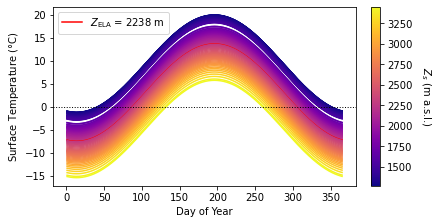

In [13]:
colormap = cm.plasma
normalize = mcolors.Normalize(vmin=np.min(Z), 
                              vmax=np.max(Z))

# Colorbar setup
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
s_map.set_array(Z[0])

# If color parameters is a linspace, we can set boundaries in this way
halfdist = (Z[0,1] - Z[0,0])/2.0
boundaries = np.linspace(Z[0,0]  - halfdist, 
                         Z[0,-1] + halfdist, 
                         11)
 
fig, ax = plt.subplots(1,1, figsize=(6,3),
                       constrained_layout=True)

for i, z in enumerate(Z[0]): 
        
    color = colormap(normalize(z))
    ax.plot(DOYs[:,0], T_s[:,i]-273.15, color=color)
    
    if i == np.argmin(np.abs(Z[0] - z_ELA)): 
        ax.plot(DOYs[:,0], T_s[:,i]-273.15, color='r',
                label='$Z_{{\\rm ELA}}$ = {:.0f} m'.format(z_ELA))

ax.axhline(0.0, ls=':', lw=1.0, c='k')

plt.legend()
cbar = fig.colorbar(s_map, 
                    spacing='proportional', 
                    ticks=np.linspace(np.round(np.min(Z),-3), 
                                      np.round(np.max(Z),-2), 11), 
                    ax=ax, 
                    boundaries=boundaries)

cbar.set_label('$Z_s$ (m a.s.l.)', rotation=270, labelpad=20)

ax.set_ylabel('Surface Temperature ($\degree $C)')
ax.set_xlabel('Day of Year')

fig.savefig('/Users/andrewnolan/Desktop/Temps.png', dpi=300,
            bbox_inches='tight', facecolor='w')

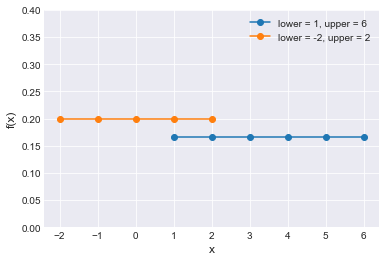

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
ls = [1, -2]
us = [6, 2]
for l, u in zip(ls, us):
    x = np.arange(l, u+1)
    pmf = [1.0 / (u - l + 1)] * len(x)
    plt.plot(x, pmf, '-o', label='lower = {}, upper = {}'.format(l, u))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 0.4)
plt.legend(loc=1)
plt.show()